In [2]:
!pip install --upgrade pip
!pip install -q sagemaker-experiments

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
  Using cached pip-22.0.4-py3-none-any.whl (2.1 MB)
  Attempting uninstall: pip
    Found existing installation: pip 21.3.1
    Uninstalling pip-21.3.1:
      Successfully uninstalled pip-21.3.1
/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_

In [3]:
import sagemaker
import boto3

session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = session.default_bucket()
region = session.boto_region_name
prefix = 'sagemaker-ml-fairness'

In [4]:
from datetime import datetime, timedelta, timezone
import json, re, os, uuid
from time import sleep, gmtime, strftime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from smexperiments.experiment import Experiment
from smexperiments.trial import Trial
from botocore.exceptions import ClientError

from sagemaker import image_uris
from sagemaker.s3 import S3Uploader, S3Downloader
from sagemaker.inputs import TrainingInput

from sagemaker import clarify

In [5]:
orig_columns=['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 
              'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 
              'hours-per-week', 'native-country', 'target']

df=pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data',
              names=orig_columns, sep=r'\s*,\s*', na_values='?', engine='python')
df_valtest=pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test', 
               names=orig_columns, skiprows=1, sep=r'\s*,\s*', na_values='?', engine='python')
df.drop(columns='education', inplace=True)
df_valtest.drop(columns='education', inplace=True)
df_valtest['target'] = df_valtest['target'].replace(to_replace=['<=50K.', '>50K.'], 
                                                    value=['<=50K', '>50K'])

# move the target column to first for XGBoost
new_columns = df.columns.tolist()
new_columns = [new_columns[-1]] + new_columns[:-1]
df = df[new_columns]
df_valtest=df_valtest[new_columns]

In [6]:
df.head()

,target,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,<=50K,39,State-gov,77516,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,<=50K,50,Self-emp-not-inc,83311,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,<=50K,38,Private,215646,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,<=50K,53,Private,234721,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,<=50K,28,Private,338409,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba


In [7]:
from sklearn import preprocessing

categorical_columns = df.select_dtypes(include='object').columns

encoder = preprocessing.OrdinalEncoder(dtype=int)

df[categorical_columns] = encoder.fit_transform(df[categorical_columns].fillna('NaN'))
df_valtest[categorical_columns]=encoder.transform(df_valtest[categorical_columns].fillna('NaN'))

In [8]:
from sklearn.model_selection import train_test_split
df_val, df_test = train_test_split(df_valtest, test_size=0.9, random_state=43, shuffle=True, stratify=df_valtest['target'])

In [9]:
df.shape, df_valtest.shape, df_val.shape, df_test.shape

((32561, 14), (16281, 14), (1628, 14), (14653, 14))

Text(0.5, 0, 'Sex (0: Female, 1: Male)')

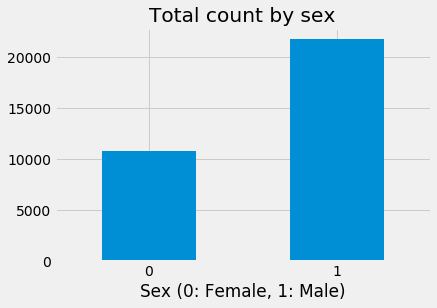

In [10]:
df['sex'].value_counts(sort=False).plot(kind='bar', title='Total count by sex', rot=0)
plt.xlabel('Sex (0: Female, 1: Male)')

Text(0.5, 0, 'target (0: <=50K, 1: >50K)')

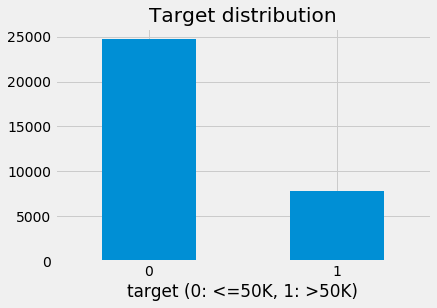

In [11]:
df['target'].value_counts(sort=False).plot(kind='bar', title='Target distribution', rot=0)
plt.xlabel('target (0: <=50K, 1: >50K)')

In [12]:
df['sex'].value_counts()

1    21790
0    10771
Name: sex, dtype: int64

Text(0.5, 0, 'Sex (0: Female, 1: Male)')

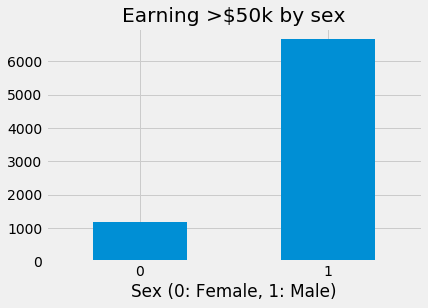

In [13]:
df[df['target']==1]['sex'].value_counts(sort=False).plot(kind='bar', title='Earning >$50k by sex', rot=0)
plt.xlabel('Sex (0: Female, 1: Male)')

In [14]:
os.makedirs('adult', exist_ok=True)

df.to_csv('adult/adult-data-train.csv', index=False, header=False)
df_val.to_csv('adult/adult-data-val.csv', index=False, header=False)

train_s3_uri = S3Uploader.upload('adult/adult-data-train.csv', f's3://{bucket}/{prefix}/adult-data')
val_s3_uri = S3Uploader.upload('adult/adult-data-val.csv', f's3://{bucket}/{prefix}/adult-data')

In [15]:
from sagemaker import clarify

clarify_processor = clarify.SageMakerClarifyProcessor(
    role = role,
    instance_count = 1,
    instance_type = 'ml.c5.2xlarge',
    sagemaker_session = session)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: 1.0.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


In [16]:
experiment_name = 'adult-income-clarify'

try:
    experiment = Experiment.create(
        experiment_name = experiment_name,
        description = 'adult income clarify experiment')
except ClientError as e:
    print(f'{experiment_name} already exists. Reusing existing experiment')

In [17]:
exp_datetime_1 = strftime('%Y-%m-%d-%H-%M-%S', gmtime())

exp_trial_1 = Trial.create(
    experiment_name = experiment_name,
    trial_name = exp_datetime_1)

experiment_config = {
    'ExperimentName': experiment_name,
    'TrialName': exp_trial_1.trial_name,
    'TrialComponentDisplayName': 'Pretraining-BiasAnalysis'}

In [18]:
pretraining_bias_report_output_path = f's3://{bucket}/{prefix}/{experiment_name}-{exp_trial_1.trial_name}/clarify-pretraining-bias'

bias_data_config = clarify.DataConfig(
    s3_data_input_path = train_s3_uri,
    s3_output_path = pretraining_bias_report_output_path,
    label = 'target',
    headers = df.columns.tolist(),
    dataset_type = 'text/csv')

In [19]:
bias_config = clarify.BiasConfig(
    label_values_or_threshold = [1],
    facet_name = ['sex', 'race'],
    facet_values_or_threshold = [[0], None])

In [20]:
jobname = f'adult-clarify-pretraining-bias-{exp_datetime_1}'

clarify_processor.run_pre_training_bias(
    data_config = bias_data_config,
    data_bias_config = bias_config,
    methods='all',
    job_name=jobname,
    experiment_config = experiment_config,
    wait=False,
    logs=False)

INFO:sagemaker:Creating processing-job with name adult-clarify-pretraining-bias-2022-04-14-21-36-41



Job Name:  adult-clarify-pretraining-bias-2022-04-14-21-36-41
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-104877823522/sagemaker-ml-fairness/adult-data/adult-data-train.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-104877823522/sagemaker-ml-fairness/adult-income-clarify-2022-04-14-21-36-41/clarify-pretraining-bias/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-us-east-1-104877823522/sagemaker-ml-fairness/adult-income-clarify-2022-04-14-21-36-41/clarif

In [21]:
# Mitigating bias

max_female_sample = df.groupby(['sex', 'target'], group_keys=False).count().loc[(0, 1)]['age']


In [22]:
df_sampled = df.groupby(['sex', 'target'], group_keys=False).apply(lambda x: x.sample(max_female_sample))
df_sampled

,target,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
20797,0,41,2,129155,7,6,7,2,2,0,0,0,40,39
11137,0,51,4,174754,9,4,8,1,2,0,0,0,38,39
26660,0,24,6,34918,11,4,8,4,4,0,0,0,38,39
12675,0,22,4,154422,10,0,12,3,1,0,0,0,30,30
17829,0,23,4,103064,13,4,13,1,4,0,0,0,40,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6533,1,35,4,188069,14,4,10,1,4,1,13550,0,55,26
12383,1,45,4,199058,14,2,3,0,4,1,7298,0,50,39
16277,1,34,4,103408,10,0,10,1,2,1,0,0,40,10
1771,1,50,4,171338,10,2,3,0,4,1,99999,0,50,39


In [23]:
df_sampled.shape

(4716, 14)

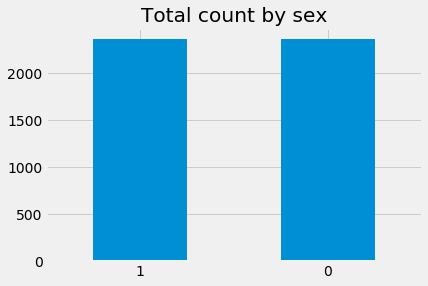

In [24]:
df_sampled['sex'].value_counts().sort_values().plot(kind='bar', title='Total count by sex', rot=0)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


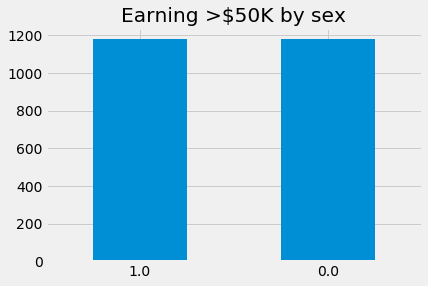

In [25]:
df_sampled['sex'].where(df_sampled['target'] == 1).value_counts().sort_values().plot(kind='bar',
                                                                                     title='Earning >$50K by sex',
                                                                                     rot=0)

In [26]:
df_sampled.to_csv('adult/adult-data-train-sampled.csv', index=False, header=False)
train_sampled_s3_uri = S3Uploader.upload('adult/adult-data-train-sampled.csv', 
                                      f's3://{bucket}/{prefix}/adult-data')

In [27]:
# Rerun the pre-training bias analysis to confirm
exp_datetime_2 = strftime('%Y-%m-%d-%H-%M-%S', gmtime())

# Creating a new trial as we are working on a new dataset
exp_trial_2 = Trial.create(experiment_name=experiment_name, 
                         trial_name=exp_datetime_2)

experiment_config={'ExperimentName': experiment_name,
                   'TrialName': exp_trial_2.trial_name,
                   'TrialComponentDisplayName': 'Pretraining-BiasAnalysis'}

pretraining_bias_report_output_path = f's3://{bucket}/{prefix}/{experiment_name}-{exp_trial_2.trial_name}/clarify-pretraining-bias'

bias_data_config = clarify.DataConfig(
    s3_data_input_path=train_sampled_s3_uri,
    s3_output_path=pretraining_bias_report_output_path,
    label='target',
    headers=df_sampled.columns.tolist(),
    dataset_type='text/csv')

bias_config = clarify.BiasConfig(
    label_values_or_threshold=[1], 
    facet_name=['sex', 'race'], 
    facet_values_or_threshold=[[0], None])

jobname = f'adult-sampled-clarify-pretraining-bias-{exp_datetime_2}'

clarify_processor.run_pre_training_bias(
    data_config=bias_data_config,
    data_bias_config=bias_config,
    methods='all',
    job_name=jobname,
    experiment_config=experiment_config,
    wait=False,
    logs=False)

INFO:sagemaker:Creating processing-job with name adult-sampled-clarify-pretraining-bias-2022-04-14-22-17-46



Job Name:  adult-sampled-clarify-pretraining-bias-2022-04-14-22-17-46
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-104877823522/sagemaker-ml-fairness/adult-data/adult-data-train-sampled.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-104877823522/sagemaker-ml-fairness/adult-income-clarify-2022-04-14-22-17-46/clarify-pretraining-bias/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-us-east-1-104877823522/sagemaker-ml-fairness/adult-income-clarify-2022-04-14

In [28]:
# Training a ML model using XGBoost

exp_datetime_3 = strftime('%Y-%m-%d-%H-%M-%S', gmtime())
jobname = f'adult-xgb-test-{exp_datetime_3}'

experiment_config={'ExperimentName': experiment_name,
                   'TrialName': exp_trial_2.trial_name,
                   'TrialComponentDisplayName': 'Training'}

image = image_uris.retrieve(region=region, framework='xgboost', version='1.3-1')

train_s3_output = f's3://{bucket}/{prefix}/{experiment_name}-{exp_trial_2.trial_name}/training'

xgb = sagemaker.estimator.Estimator(image,
                                    role,
                                    instance_type='ml.m5.xlarge',
                                    instance_count=1,
                                    output_path=train_s3_output,
                                    enable_sagemaker_metrics=True,
                                    sagemaker_session=session)
xgb.set_hyperparameters(objective='binary:logistic',
                        eval_metric='error',
                        num_round=50)

train_input = sagemaker.inputs.TrainingInput(s3_data=train_sampled_s3_uri, 
                                             content_type='csv')

val_input = sagemaker.inputs.TrainingInput(s3_data=val_s3_uri, 
                                             content_type='csv')

data_channels={'train': train_input, 'validation': val_input}

xgb.fit(inputs=data_channels, 
        job_name=jobname, 
        experiment_config=experiment_config, 
        wait=True)

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: adult-xgb-test-2022-04-14-22-27-32


2022-04-14 22:27:33 Starting - Starting the training job...
2022-04-14 22:27:59 Starting - Preparing the instances for trainingProfilerReport-1649975252: InProgress
......
2022-04-14 22:29:00 Downloading - Downloading input data...
2022-04-14 22:29:29 Training - Downloading the training image......
2022-04-14 22:30:25 Uploading - Uploading generated training model[2022-04-14 22:30:18.182 ip-10-0-165-232.ec2.internal:1 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-04-14:22:30:18:INFO] Imported framework sagemaker_xgboost_container.training
[2022-04-14:22:30:18:INFO] Failed to parse hyperparameter eval_metric value error to Json.
Returning the value itself
[2022-04-14:22:30:18:INFO] Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
[2022-04-14:22:30:18:INFO] No GPUs detected (normal if no gpus installed)
[2022-04-14:22:30:18:INFO] Running XGBoost Sagemaker in algorithm mode
[2022-04-14:22:30:18:INFO] Determined delimiter of C

In [29]:
model_name = f'adult-xgb-test-model-{exp_datetime_3}'
model = xgb.create_model(name=model_name)

container_def = model.prepare_container_def()
session.create_model(model_name, role, container_def)

INFO:sagemaker:Creating model with name: adult-xgb-test-model-2022-04-14-22-27-32


'adult-xgb-test-model-2022-04-14-22-27-32'

In [30]:
# Detecting post-training bias

experiment_config={'ExperimentName': experiment_name,
                   'TrialName': exp_trial_2.trial_name,
                   'TrialComponentDisplayName': 'Posttraining-BiasAnalysis'}

posttraining_bias_report_output_path = f's3://{bucket}/{prefix}/{experiment_name}-{exp_trial_2.trial_name}/clarify-posttraining-bias'

bias_data_config = clarify.DataConfig(
    s3_data_input_path=train_sampled_s3_uri,
    s3_output_path=posttraining_bias_report_output_path,
    label='target',
    headers=df_sampled.columns.tolist(),
    dataset_type='text/csv')

bias_config = clarify.BiasConfig(
    label_values_or_threshold=[1], 
    facet_name=['sex', 'race'], 
    facet_values_or_threshold=[[0], None])

In [31]:
model_config = clarify.ModelConfig(
    model_name=model_name,
    instance_type='ml.m5.xlarge',
    instance_count=1,
    accept_type='text/csv',
    content_type='text/csv')

predictions_config = clarify.ModelPredictedLabelConfig(probability_threshold=0.5)

In [32]:
exp_datetime_4 = strftime('%Y-%m-%d-%H-%M-%S', gmtime())
jobname = f'adult-sampled-clarify-posttraining-bias-{exp_datetime_4}'

clarify_processor.run_post_training_bias(
    data_config=bias_data_config,
    data_bias_config=bias_config,
    model_config=model_config,
    model_predicted_label_config=predictions_config,
    methods='all',    
    job_name=jobname,
    experiment_config=experiment_config,
    wait=False,
    logs=False)

INFO:sagemaker:Creating processing-job with name adult-sampled-clarify-posttraining-bias-2022-04-14-22-34-52



Job Name:  adult-sampled-clarify-posttraining-bias-2022-04-14-22-34-52
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-104877823522/sagemaker-ml-fairness/adult-data/adult-data-train-sampled.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-104877823522/sagemaker-ml-fairness/adult-income-clarify-2022-04-14-22-17-46/clarify-posttraining-bias/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-us-east-1-104877823522/sagemaker-ml-fairness/adult-income-clarify-2022-04-

In [33]:
# Explaining ML models using SHAP values

experiment_config={'ExperimentName': experiment_name,
                   'TrialName': exp_trial_2.trial_name,
                   'TrialComponentDisplayName': 'Posttraining-SHAP'}

explainability_output_path = f's3://{bucket}/{prefix}/{experiment_name}-{exp_trial_2.trial_name}/clarify-explainability'

explainability_data_config = clarify.DataConfig(
    s3_data_input_path=train_sampled_s3_uri,
    s3_output_path=explainability_output_path,
    label='target',
    headers=df_sampled.columns.tolist(),
    dataset_type='text/csv')

model_config = clarify.ModelConfig(
    model_name=model_name,
    instance_type='ml.m5.xlarge',
    instance_count=1,
    accept_type='text/csv',
    content_type='text/csv')

baseline = df_sampled.query('target == 1').mode().iloc[0, 1:].astype(int).tolist()
shap_config = clarify.SHAPConfig(
    baseline=[baseline],
    num_samples=15,
    agg_method='mean_abs')

In [34]:
exp_datetime_5 = strftime('%Y-%m-%d-%H-%M-%S', gmtime())
jobname = f'adult-sampled-clarify-posttraining-shap-{exp_datetime_5}'

clarify_processor.run_explainability(
    data_config=explainability_data_config,
    model_config=model_config,
    explainability_config=shap_config,
    job_name=jobname,
    experiment_config=experiment_config)

INFO:sagemaker:Creating processing-job with name adult-sampled-clarify-posttraining-shap-2022-04-14-22-45-01



Job Name:  adult-sampled-clarify-posttraining-shap-2022-04-14-22-45-01
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-104877823522/sagemaker-ml-fairness/adult-data/adult-data-train-sampled.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-104877823522/sagemaker-ml-fairness/adult-income-clarify-2022-04-14-22-17-46/clarify-explainability/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-us-east-1-104877823522/sagemaker-ml-fairness/adult-income-clarify-2022-04-14-

In [ ]:
S3Downloader.download(f'{explainability_output_path}/explanations_shap/out.csv', 
                      './',
                      sagemaker_session=sess)
local_explanations_out = pd.read_csv('out.csv')
feature_names = [str.replace(c, '_label0', '') 
                 for c in local_explanations_out.columns.to_series()]
local_explanations_out.columns = feature_names

selected_example = 500
sample_prediction='>50K' if sum(local_explanations_out.iloc[selected_example]) > 0 else '<=50K'
print(f'Example number: {selected_example}')
print(f'with model prediction: {sample_prediction}')
print()
print(f'Feature values: \n{df_sampled.iloc[selected_example].to_frame().T}')

local_explanations_out.iloc[selected_example].plot(
    kind='barh', 
    title=f'Local explanation for the {selected_example}th example.', 
    rot=0)